# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#




## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [1]:
pathToFile = "./"
fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

FileNotFoundError: [Errno 2] No such file or directory: './LD2011_2014.txt' -> './LD2011_2014.txt.bak'

In [5]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [6]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 16:15:00,2.538071,29.160740,1.737619,152.439024,63.414634,267.857143,6.218202,333.333333,69.930070,40.860215,...,437.544611,38000.0,2603.375527,3863.636364,117.340287,4.6811,499.561018,121.869783,727.272727,12378.378378
2014-12-31 16:30:00,3.807107,28.449502,1.737619,162.601626,71.951220,250.000000,7.348785,356.902357,68.181818,47.311828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.shape

(140226, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140226 entries, 2011-01-01 00:15:00 to 2014-12-31 16:30:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 396.9+ MB


In [10]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140226.000000,140226.000000,140226.000000,140226.000000,140226.000000,140226.000000,140226.000000,140226.000000,140226.000000,140226.000000,...,140225.000000,140225.000000,140225.000000,140225.000000,140225.000000,140225.000000,140225.000000,140225.000000,140225.000000,140225.000000
mean,3.971164,20.767542,2.918523,82.163836,37.230031,141.187644,4.519938,191.376441,39.966477,42.198201,...,218.182123,37607.803887,1887.365769,2940.125124,65.408857,9.270385,424.239815,94.699212,625.238376,8722.285863
std,5.984542,13.273599,11.015623,58.236640,26.454525,98.410518,6.485625,121.980072,29.810995,33.401189,...,204.842313,38696.129757,1801.654871,2732.486617,65.011955,10.017717,274.358183,80.301357,380.696892,9196.134099
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.133713,0.000000,34.552846,14.634146,68.452381,0.565291,78.282828,12.237762,9.677419,...,0.000000,0.000000,0.000000,0.000000,11.734029,0.000000,0.000000,5.008347,68.914956,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

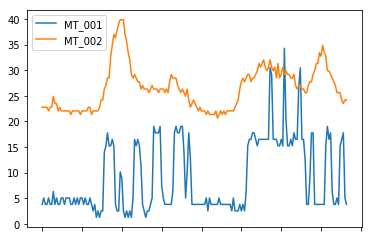

In [11]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

In [12]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.head()

,MT_001,MT_002
2012-01-01 00:15:00,3.807107,22.759602
2012-01-01 00:30:00,5.076142,22.759602
2012-01-01 00:45:00,3.807107,22.759602
2012-01-01 01:00:00,3.807107,22.759602
2012-01-01 01:15:00,5.076142,22.048364


#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [13]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [14]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
364.6875


In [15]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [16]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70050, 349)
0


## Getting average curves per client

In [17]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [18]:
data['hour'] = data.index.map(lambda x: x[11:])

In [19]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [20]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

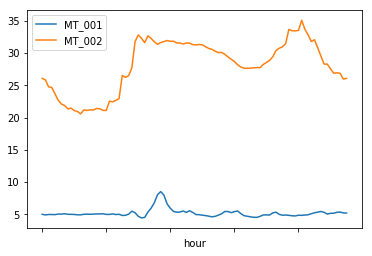

In [21]:
average_curves
data_example = average_curves.loc[:][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### The dataframe average_curves contains the 349 (????) typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

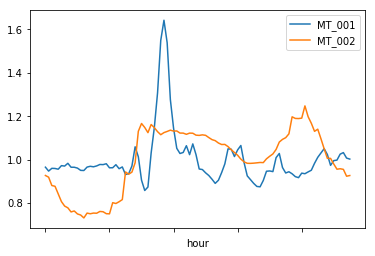

In [22]:
average_curves_norm = average_curves/(average_curves.mean())
data_example = average_curves_norm.loc[:][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### Plot the first 2 and last 2 clients

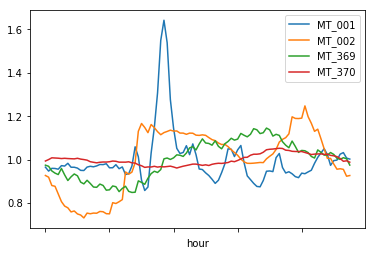

In [23]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [24]:
#Since the cluster analysis we want to do is to find similar customers, we need to have rows with
#customers. This is way we will  

X = average_curves_norm.copy()
XT = np.array(X.T) # put it on the right format

pd.DataFrame(XT).head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.965219,0.947156,0.959879,0.959209,0.955861,0.972266,0.970258,0.982980,0.964901,0.964901,...,1.030595,1.050375,1.023554,0.973600,0.995392,0.997739,1.025230,1.032271,1.007126,1.002433
1,0.926906,0.919051,0.880680,0.877180,0.841929,0.806643,0.786020,0.777978,0.759053,0.763524,...,1.096148,1.050019,1.005939,1.005730,0.979560,0.955784,0.957936,0.955125,0.923539,0.926733
2,0.991896,0.977752,0.976535,0.971664,0.953400,0.949138,0.954617,0.947312,0.918698,0.925395,...,1.111997,1.101633,1.093098,1.082124,1.069321,1.038229,1.009576,1.004089,0.998602,0.993115
3,1.139649,1.099277,1.061755,1.030264,0.975865,0.921005,0.897441,0.875944,0.855542,0.836306,...,1.503257,1.495977,1.463151,1.422802,1.389952,1.347411,1.293669,1.238782,1.209585,1.175031
4,1.186069,1.131906,1.090434,1.054149,1.024531,0.993172,0.962930,0.934953,0.919159,0.904119,...,1.365964,1.375927,1.382076,1.388126,1.385857,1.369186,1.352088,1.324402,1.272580,1.231150


## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

This is a typo. It should be "Using the function in Module 4, ...". It means "getInertia" and related codes in the Module 4 notebook.

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

# Exercise 1 - A - Initial Exploration

Before optimizing the k, n this section, I will apply the k-means algorithm using some initial intuitive values for k to see what I can find manually. My goal is to intuitivelly see how the clusters look like. In the next section I will aproximate the optimal value for K based on minimal inertia and silhoutte 

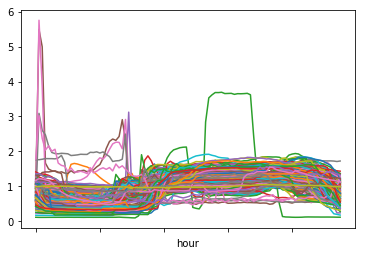

In [25]:
#LEt's plot all customers to sse how it looks for k=1

X.plot().legend().set_visible(False)
plt.show()

In [26]:
from sklearn.cluster import KMeans
random_state = 170

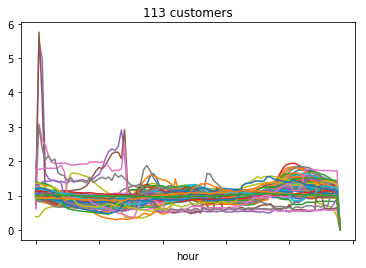

In [27]:
# now, let use the kmeans algorithm to cluster customers into 2 groups 
# and see the differentce
# since customers need to be rows we we createa a transpose

XT = pd.DataFrame(average_curves_norm).transpose()

kmeans2 = KMeans(n_clusters=2, random_state=random_state);
XT['labels'] = kmeans2.fit_predict(XT)
cluster0 = XT[XT['labels']==0]
cluster1 = XT[XT['labels']==1]
len(cluster0), len(cluster1)

# to chart, we transpose te cluster again
cluster0.transpose().plot().legend().set_visible(False)
plt.title(str(len(cluster0)) + " customers")
plt.show()

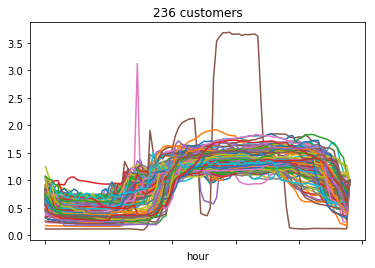

In [28]:
# to chart, we transpose te cluster again
cluster1.transpose().plot().legend().set_visible(False)
plt.title(str(len(cluster1)) + " customers")
plt.show()

# Two clusters already show something interesting

the second cluster clearly shows a pattern of consume that show energy consumption during the day and very low ocnsumption in the middle of the night. The other grouphave a more consisten energy use over the da.


In [29]:
kmeans2.inertia_

1175.821776759586

# Exploring 5 (4) clusters and its centroids

In [30]:
kmeans5=KMeans(n_clusters=5, random_state=random_state)
XT['labels'] = kmeans5.fit_predict(XT)
cluster0_5 = XT[XT['labels']==0]
cluster1_5 = XT[XT['labels']==1]
cluster2_5 = XT[XT['labels']==2]
cluster3_5 = XT[XT['labels']==3]
cluster4_5 = XT[XT['labels']==4]
len(cluster0_5), len(cluster1_5),len(cluster2_5),len(cluster3_5),len(cluster4_5)

(199, 35, 110, 4, 1)

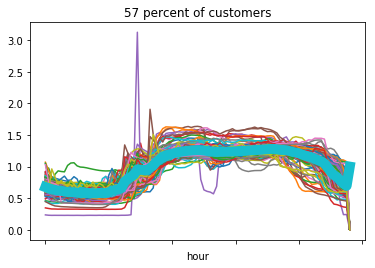

In [31]:
import math as m
cluster0_5.transpose().plot().legend().set_visible(False)
centers = pd.DataFrame(kmeans5.cluster_centers_).transpose()[0]
centers.plot(linewidth=10).legend().set_visible(False)
plt.title(str(m.floor(len(cluster0_5)/len(XT)*100)) + " percent of customers")
plt.show()

# Cluster 1 seems to be of normal residential customers?

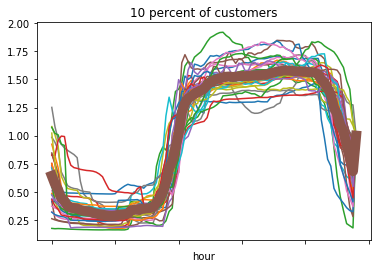

In [32]:
cluster1_5.transpose().plot().legend().set_visible(False)
centers = pd.DataFrame(kmeans5.cluster_centers_).transpose()[1]
centers.plot(linewidth=10).legend().set_visible(False)
plt.title(str(m.floor(len(cluster1_5)/len(XT)*100)) + " percent of customers")
plt.show()

# I would say cluster 2 one looks like office space 9 to 5

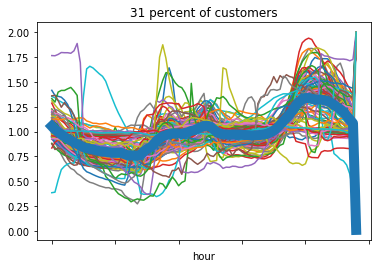

In [33]:
cluster2_5.transpose().plot().legend().set_visible(False)
centers = pd.DataFrame(kmeans5.cluster_centers_).transpose()[2]
centers.plot(linewidth=10).legend().set_visible(False)
plt.title(str(m.floor(len(cluster2_5)/len(XT)*100)) + " percent of customers")
plt.show()

# Consume increases until pretty late and then sharply falls which maybe is retail space open to public until late?

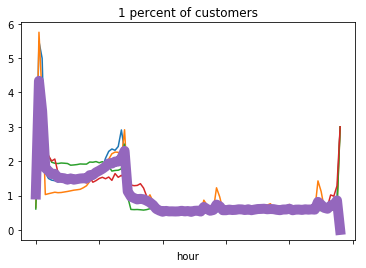

In [34]:
cluster3_5.transpose().plot().legend().set_visible(False)
centers = pd.DataFrame(kmeans5.cluster_centers_).transpose()[3]
centers.plot(linewidth=10).legend().set_visible(False)
plt.title(str(m.floor(len(cluster3_5)/len(XT)*100)) + " percent of customers")
plt.show()

#  Cluster 4 is very distintive, energy consuption is high at early night and then goes down during the day. Very small percentage Maybe security or something that runs at night,


# Cluster 5 has only one element , not too meaningful but still interesting as this customer has a rare dropin the middle of the day

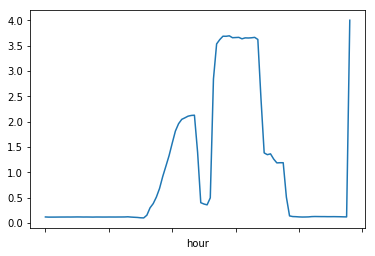

In [35]:
cluster4_5.transpose().plot().legend().set_visible(False)
plt.show()

In [36]:
#Intertia for k = 5
kmeans5.inertia_

555.0768474551146

# Calculating the Optimal K for 340 customers using inertia and silhouette.
### 20 is around square root of 340. So we will look for values in that range.



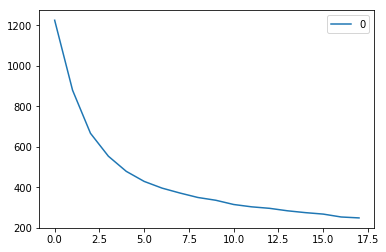

In [37]:
# here i calculate all inertias and plot them
inertias = []
for k in range(2,20):
    kmeans_model=KMeans(n_clusters=k, random_state=random_state)
    kmeans_model.fit_predict(XT)
    inertias.append(kmeans_model.inertia_)
    
pd.DataFrame(inertias).plot()

# Calculating the Silhouette

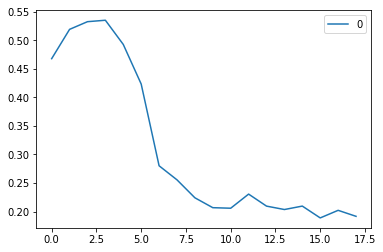

In [38]:
# here i calculate all Silhouette and plot them
from sklearn.metrics import silhouette_score

silhouettes = []

for k in range(2,20):
    kmeans_model=KMeans(n_clusters=k, random_state=random_state)
    kmeans_model.fit_predict(XT)
    silhouettes.append( silhouette_score(XT, kmeans_model.labels_) )
    
pd.DataFrame(silhouettes).plot()

In [39]:
# plot the entroid
#https://python-graph-gallery.com/123-highlight-a-line-in-line-plot/


# An optimal k according to inertia and siluethe  a seems to be around  4, which make sense with the intuitive observations.

In this particular application, the problem is about finding interesting clusters that can serve to segment customer into different consumer pattern 


## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. ==> 2

b. What are the clusters that you obtained represent?


# Spoiler, it looks this is a comercial customer that stops for weekends. So the two clusters represent weekends and weekdays,

In [40]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,31.133250,28.642590,27.397260,24.906600,24.283935,26.151930,26.151930,24.906600,26.774595,23.661270,...,31.133250,28.019925,26.774595,26.774595,24.906600,26.151930,27.397260,26.774595,23.661270,24.283935
1,22.415940,22.415940,20.547945,20.547945,22.415940,21.793275,19.925280,23.038605,20.547945,21.170610,...,29.265255,28.642590,26.774595,28.642590,26.774595,24.906600,23.038605,23.038605,23.661270,24.283935
2,21.793275,21.170610,20.547945,19.925280,19.302615,20.547945,18.057285,18.679950,18.057285,17.434620,...,31.755915,31.755915,32.378580,33.001245,29.265255,26.774595,28.019925,26.774595,28.019925,26.151930
3,23.661270,22.415940,22.415940,21.793275,22.415940,20.547945,21.170610,21.170610,21.793275,21.793275,...,30.510585,27.397260,28.019925,27.397260,28.019925,26.774595,29.887920,28.642590,26.774595,24.906600
4,19.925280,19.302615,19.925280,19.302615,18.057285,18.679950,18.057285,18.057285,18.057285,19.302615,...,33.623910,33.001245,27.397260,27.397260,30.510585,29.265255,29.887920,30.510585,26.151930,28.019925


# Calculating inertia and silhouette to determine an optimal k
here i do not need to transpose as the matrix is in the right format.
each row represents a day and the columns are the 24 x 4 moments in the day

# First, deal with nulls
Some columns have  1 (one) null value

In [45]:
XX = pd.DataFrame(X)
XX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 96 columns):
0     730 non-null float64
1     730 non-null float64
2     730 non-null float64
3     730 non-null float64
4     730 non-null float64
5     730 non-null float64
6     730 non-null float64
7     730 non-null float64
8     730 non-null float64
9     730 non-null float64
10    730 non-null float64
11    730 non-null float64
12    730 non-null float64
13    730 non-null float64
14    730 non-null float64
15    730 non-null float64
16    730 non-null float64
17    730 non-null float64
18    730 non-null float64
19    730 non-null float64
20    730 non-null float64
21    730 non-null float64
22    730 non-null float64
23    730 non-null float64
24    730 non-null float64
25    730 non-null float64
26    730 non-null float64
27    730 non-null float64
28    730 non-null float64
29    730 non-null float64
30    730 non-null float64
31    730 non-null float64
32    730 non-null float64
33  

In [49]:
XX.isnull().values.any()

True

In [55]:
XXX = XX[0:95]
XXX.isnull().values.any()

False

# We are lucky, just removing the last column is enough

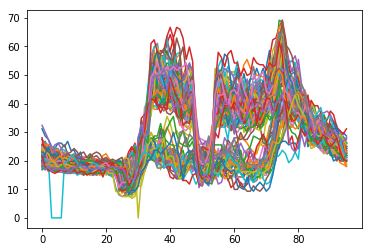

In [58]:
# Let see how k=1 looks in a plot

XXX.transpose().plot().legend().set_visible(False)

# Crealy there is a nice opportunity to group the days in certain cluster as we can see a lot of dispertion during the day.

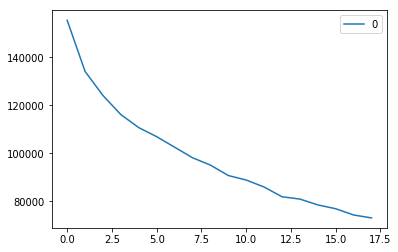

In [56]:
# here i calculate all inertias and plot them
inertias = []
for k in range(2,20):
    kmeans_model=KMeans(n_clusters=k, random_state=random_state)
    kmeans_model.fit_predict(XXX)
    inertias.append(kmeans_model.inertia_)
    
pd.DataFrame(inertias).plot()

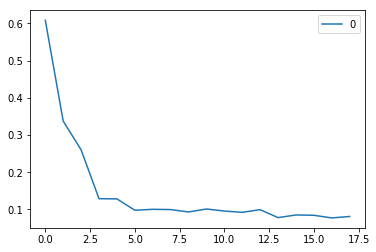

In [60]:
silhouettes = []

for k in range(2,20):
    kmeans_model=KMeans(n_clusters=k, random_state=random_state)
    kmeans_model.fit_predict(XXX)
    silhouettes.append( silhouette_score(XXX, kmeans_model.labels_) )
    
pd.DataFrame(silhouettes).plot()

# Silhouette goes down too fast so probably we should stick to a value of 2. Let's see how two cluster look like

/Users/pabloelustondo/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


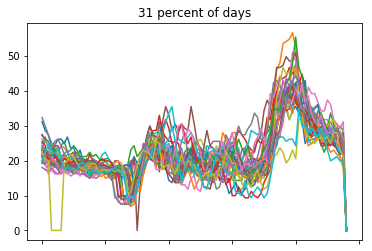

In [63]:


kmeans2 = KMeans(n_clusters=2, random_state=random_state);
XXX['labels'] = kmeans2.fit_predict(XXX)
cluster0 = XXX[XXX['labels']==0]
cluster1 = XXX[XXX['labels']==1]
len(cluster0), len(cluster1)

# to chart, we transpose te cluster again
cluster0.transpose().plot().legend().set_visible(False)
plt.title(str(m.floor(len(cluster0)/len(XXX)*100)) + " percent of days")
plt.show()

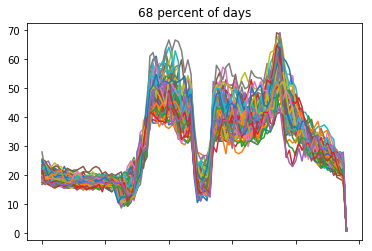

In [64]:
# to chart, we transpose te cluster again
cluster1.transpose().plot().legend().set_visible(False)
plt.title(str(m.floor(len(cluster1)/len(XXX)*100)) + " percent of days")
plt.show()

# Intuitive Hipothesis:

### I suspect that this is a comercial customer, maybe a factory. Almost 70 of the days this customer is consuming energy and droping the consume at midday for lunch.

### the 30% rest of the days (maybe weekends) the shop is closed or does something different

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [66]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
     daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

# Is easy to see that cluster 0 contains, essencially, weekends. For example, you have 11,12, then 5 days no and then you have 18,19 then 5 days not ten 25,26 ... etc.

In [76]:

cluster0[:10]

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,labels
0,31.133250,28.642590,27.397260,24.906600,24.283935,26.151930,26.151930,24.906600,26.774595,23.661270,...,28.019925,26.774595,26.774595,24.906600,26.151930,27.397260,26.774595,23.661270,24.283935,0
4,19.925280,19.302615,19.925280,19.302615,18.057285,18.679950,18.057285,18.057285,18.057285,19.302615,...,33.001245,27.397260,27.397260,30.510585,29.265255,29.887920,30.510585,26.151930,28.019925,0
5,27.397260,25.529265,24.283935,23.661270,23.038605,22.415940,24.283935,25.529265,22.415940,23.038605,...,27.397260,24.906600,22.415940,24.906600,26.151930,24.283935,25.529265,24.283935,24.906600,0
11,23.661270,23.038605,23.038605,24.283935,20.547945,21.793275,19.925280,19.302615,19.302615,21.793275,...,27.397260,26.774595,24.283935,26.151930,26.774595,24.283935,23.661270,24.283935,24.283935,0
12,24.906600,26.774595,23.661270,21.793275,18.679950,17.434620,18.057285,18.057285,16.811955,18.679950,...,29.265255,28.019925,25.529265,26.774595,26.151930,26.151930,24.906600,24.283935,23.661270,0
18,21.170610,19.925280,19.925280,19.302615,19.302615,17.434620,16.189290,17.434620,18.057285,16.811955,...,28.642590,28.019925,28.019925,28.642590,26.774595,26.151930,26.774595,23.661270,24.283935,0
19,24.283935,22.415940,23.038605,23.661270,24.906600,22.415940,24.283935,23.661270,22.415940,20.547945,...,32.378580,32.378580,31.755915,31.755915,28.642590,26.774595,29.265255,25.529265,23.661270,0
25,19.925280,18.679950,18.057285,18.679950,19.302615,18.679950,16.811955,16.811955,17.434620,16.811955,...,26.774595,27.397260,28.019925,26.151930,24.283935,25.529265,23.661270,24.906600,24.283935,0
26,26.151930,26.151930,24.283935,24.906600,23.038605,19.302615,19.302615,21.170610,19.302615,19.925280,...,28.019925,26.774595,29.265255,29.887920,29.887920,28.642590,24.906600,20.547945,18.057285,0
32,21.793275,19.925280,21.170610,21.170610,18.057285,18.679950,18.057285,18.057285,19.302615,17.434620,...,26.151930,26.774595,27.397260,26.774595,28.642590,29.265255,26.774595,25.529265,21.793275,0


#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [55]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

In [ ]:


# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()
Total running time of the script: ( 0 minutes 0.284 seconds)

Download Python source code: plot_kmeans_assumptions.py
 
Download Jupyter notebook: plot_kmeans_assumptions.ipynb
Generated by Sphinx-Gallery

© 2007 - 2017, scikit-learn developers (BSD License). Show this page source